In [1]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
def load_statistic_tables(csv_dir, file_pattern="statistic_metrics_*.csv", round_digits=3):
    csv_files = sorted(glob(os.path.join(csv_dir, file_pattern)))
    stat_groups = {}

    for file in csv_files:
        base = os.path.basename(file)
        method_name = base.replace("statistic_metrics_", "").replace(".csv", "")
        df = pd.read_csv(file)

        for _, row in df.iterrows():
            stat = row["Statistic"]
            if stat not in stat_groups:
                stat_groups[stat] = []

            row_data = row.to_dict()
            row_data["Method"] = method_name
            stat_groups[stat].append(row_data)

    stat_tables = {}
    for stat, records in stat_groups.items():
        df = pd.DataFrame(records)
        df = df[["Method", "Statistic"] + [col for col in df.columns if col not in ["Method", "Statistic"]]]
        df = df.set_index("Method")
        stat_tables[stat.lower()] = df.round(round_digits) # 用小写key存储
        # for saving CSV
        # df.to_csv(f"{stat.lower()}_table.csv")
    return stat_tables

In [3]:
def plot_metrics_vs_mos(mos_csv_path, metrics_csv_path, cols=3):
    mos_df = pd.read_csv(mos_csv_path)
    metrics_df = pd.read_csv(metrics_csv_path)

    mos_df['filename'] = mos_df['filename'].str.strip().str.lower()
    metrics_df['filename'] = metrics_df['filename'].str.strip().str.lower()

    df = pd.merge(metrics_df, mos_df[['filename', 'MOS']], on='filename')
    # print(f"Merged dataframe shape: {df.shape}")
    if df.shape[0] == 0:
        print("Warning: No matching filenames after merge.")
        return

    metric_columns = [col for col in df.columns if col not in ['filename', 'MOS']]
    num_metrics = len(metric_columns)
    rows = math.ceil(num_metrics / cols)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, column in enumerate(metric_columns):
        sns.scatterplot(x=df[column], y=df['MOS'], ax=axes[i])
        axes[i].set_title(f'{column} vs MOS')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('MOS')

    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
def plot_metrics_vs_mos_multi(mos_csv_path, metrics_csv_paths, labels, cols=3):
    mos_df = pd.read_csv(mos_csv_path)
    mos_df['filename'] = mos_df['filename'].str.strip().str.lower()

    all_data = []
    for path, label in zip(metrics_csv_paths, labels):
        metrics_df = pd.read_csv(path)
        metrics_df['filename'] = metrics_df['filename'].str.strip().str.lower()

        merged_df = pd.merge(metrics_df, mos_df[['filename', 'MOS']], on='filename')
        if merged_df.shape[0] == 0:
            print(f"Warning: No matched filenames for {label}")
            continue

        merged_df['method'] = label
        all_data.append(merged_df)
    df = pd.concat(all_data, ignore_index=True)

    desired_order = ['PSNR', 'SSIM', 'LPIPS', 'CAMBI', 'BBAND', 'DBI']
    metric_columns = [col for col in desired_order if col in df.columns]
    num_metrics = len(metric_columns)
    rows = math.ceil(num_metrics / cols)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, column in enumerate(metric_columns):
        sns.scatterplot(data=df, x=column, y='MOS', hue='method', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'{column} vs MOS')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('MOS')
        axes[i].legend(loc='best', fontsize=8)

    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"MOS vs Metrics: BAND-2k", fontsize=16, y=1.02)
    plt.tight_layout()
    # plt.savefig("../test_img/mos_vs_metrics_BAND-2k.png", dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def compare_metric_distribution(csv_paths, dataset_name, labels=None, cols=3):
    dataframes = [pd.read_csv(path).drop(columns=['filename']) for path in csv_paths]
    desired_order = ['PSNR', 'SSIM', 'LPIPS', 'CAMBI', 'BBAND', 'DBI']
    common_columns = [col for col in desired_order if all(col in df.columns for df in dataframes)]
    
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(csv_paths))]
    num_metrics = len(common_columns)
    rows = math.ceil(num_metrics / cols)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, column in enumerate(common_columns):
        for df, label in zip(dataframes, labels):
            sns.kdeplot(df[column], label=label, ax=axes[i], linewidth=2)
            # sns.kdeplot(df[column], label=label, ax=axes[i], fill=True, alpha=0.3)
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='best', fontsize=8)
    
    # palette = sns.color_palette("Set1", n_colors=len(labels))
    # for i, column in enumerate(common_columns):
    #     for df, label, color in zip(dataframes, labels, palette):
    #         sns.kdeplot(df[column], label=label, ax=axes[i], color=color, linewidth=2)
    #     axes[i].set_title(f'Distribution of {column}')
    #     axes[i].set_xlabel(column)
    #     axes[i].set_ylabel('Density')
    #     axes[i].legend(fontsize=8)
    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"Metric Distribution Comparison: {dataset_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"../test_img/metrics_distribution_{dataset_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
csv_dir = "./combined_metrics/deepDeband_less_iter"
print(csv_dir)
deepDeband_tables = load_statistic_tables(csv_dir)
mean_df = deepDeband_tables["mean"]
mean_df

./combined_metrics/deepDeband_less_iter


,Statistic,PSNR,SSIM,LPIPS,CAMBI,BBAND
Method,,,,,,
WaveMamba-dwt_less_iter,Mean,40.790,0.987,0.038,3.380,1.216
WaveMamba-map_less_iter,Mean,29.546,0.916,0.266,0.926,0.891
WaveMamba_less_iter,Mean,40.985,0.987,0.038,3.515,1.217
WaveMamba_less_iter_wavelet,Mean,40.875,0.987,0.035,3.197,1.238


In [6]:
csv_dir = "./combined_metrics/deepDeband_eval"
print(csv_dir)
deepDeband_tables = load_statistic_tables(csv_dir)
mean_df = deepDeband_tables["mean"]
mean_df.to_csv(f"../test_img/deepDeband_eval_metrics.csv")
mean_df

./combined_metrics/deepDeband_eval


,Statistic,PSNR,SSIM,LPIPS,CAMBI,BBAND,DBI
Method,,,,,,,
debanded_with_deepDeband,Mean,34.584,0.964,0.071,0.057,0.464,0.122
debanded_with_dip,Mean,34.364,0.957,0.093,1.728,0.820,0.034
debanded_with_ffmpeg,Mean,31.383,0.941,0.110,0.955,0.632,0.035
debanded_with_ldm,Mean,30.597,0.905,0.140,0.824,0.853,0.057
debanded_with_ppp,Mean,32.432,0.927,0.188,3.619,1.230,0.005
debanded_with_ww_deepDeband,Mean,35.005,0.967,0.066,0.055,0.484,0.104


In [7]:
csv_dir = "./combined_metrics/deepDeband"
print(csv_dir)
deepDeband_tables = load_statistic_tables(csv_dir)
mean_df = deepDeband_tables["mean"]
mean_df.to_csv(f"../test_img/deepDeband_metrics.csv")
mean_df

./combined_metrics/deepDeband


,Statistic,PSNR,SSIM,LPIPS,CAMBI,BBAND,DBI
Method,,,,,,,
Banded_Input,Mean,36.286,0.977,0.081,1.467,1.217,0.083
WaveMamba-dwt,Mean,42.111,0.988,0.036,3.798,1.403,0.022
WaveMamba-map,Mean,41.546,0.988,0.037,3.523,1.343,0.022
WaveMamba,Mean,42.399,0.989,0.037,3.947,1.410,0.021
WaveMamba_wavelet,Mean,42.201,0.988,0.033,3.615,1.436,0.021


In [8]:
csv_dir = "./combined_metrics/HD_images_dataset_dbi"
print(csv_dir)
deepDeband_tables = load_statistic_tables(csv_dir)
mean_df = deepDeband_tables["mean"]
mean_df.to_csv(f"../test_img/HD_images_dataset_dbi_metrics.csv")
mean_df

./combined_metrics/HD_images_dataset_dbi


,Statistic,PSNR,SSIM,LPIPS,CAMBI,BBAND,DBI
Method,,,,,,,
WaveMamba-dwt,Mean,38.970,0.977,0.045,0.616,0.412,0.128
WaveMamba-map,Mean,38.826,0.977,0.048,0.519,0.365,0.082
WaveMamba,Mean,39.037,0.977,0.046,0.543,0.386,0.133
WaveMamba_wavelet,Mean,39.339,0.977,0.044,0.525,0.398,0.139
deepDeband-f,Mean,32.956,0.906,0.079,0.375,0.154,0.166
deepDeband-f_wavelet,Mean,33.237,0.907,0.078,0.374,0.153,0.168


In [9]:
csv_dir = './combined_metrics/BAND-2k'
print(csv_dir)
band2k_tables = load_statistic_tables(csv_dir)
mean_df = band2k_tables["mean"]
mean_df.to_csv(f"../test_img/BAND-2k_metrics.csv")
mean_df

./combined_metrics/BAND-2k


,Statistic,PSNR,SSIM,LPIPS,CAMBI,BBAND,DBI
Method,,,,,,,
Banded_Input,Mean,37.344,0.964,0.100,0.513,0.564,0.431
WaveMamba-dwt,Mean,38.963,0.977,0.062,0.702,0.551,0.158
WaveMamba-map,Mean,38.505,0.976,0.066,0.691,0.476,0.082
WaveMamba,Mean,38.926,0.977,0.063,0.647,0.519,0.148
WaveMamba_wavelet,Mean,39.054,0.977,0.059,0.639,0.541,0.157
deepDeband-f,Mean,33.130,0.897,0.116,0.561,0.198,0.225
deepDeband-f_wavelet,Mean,33.263,0.898,0.115,0.557,0.198,0.227


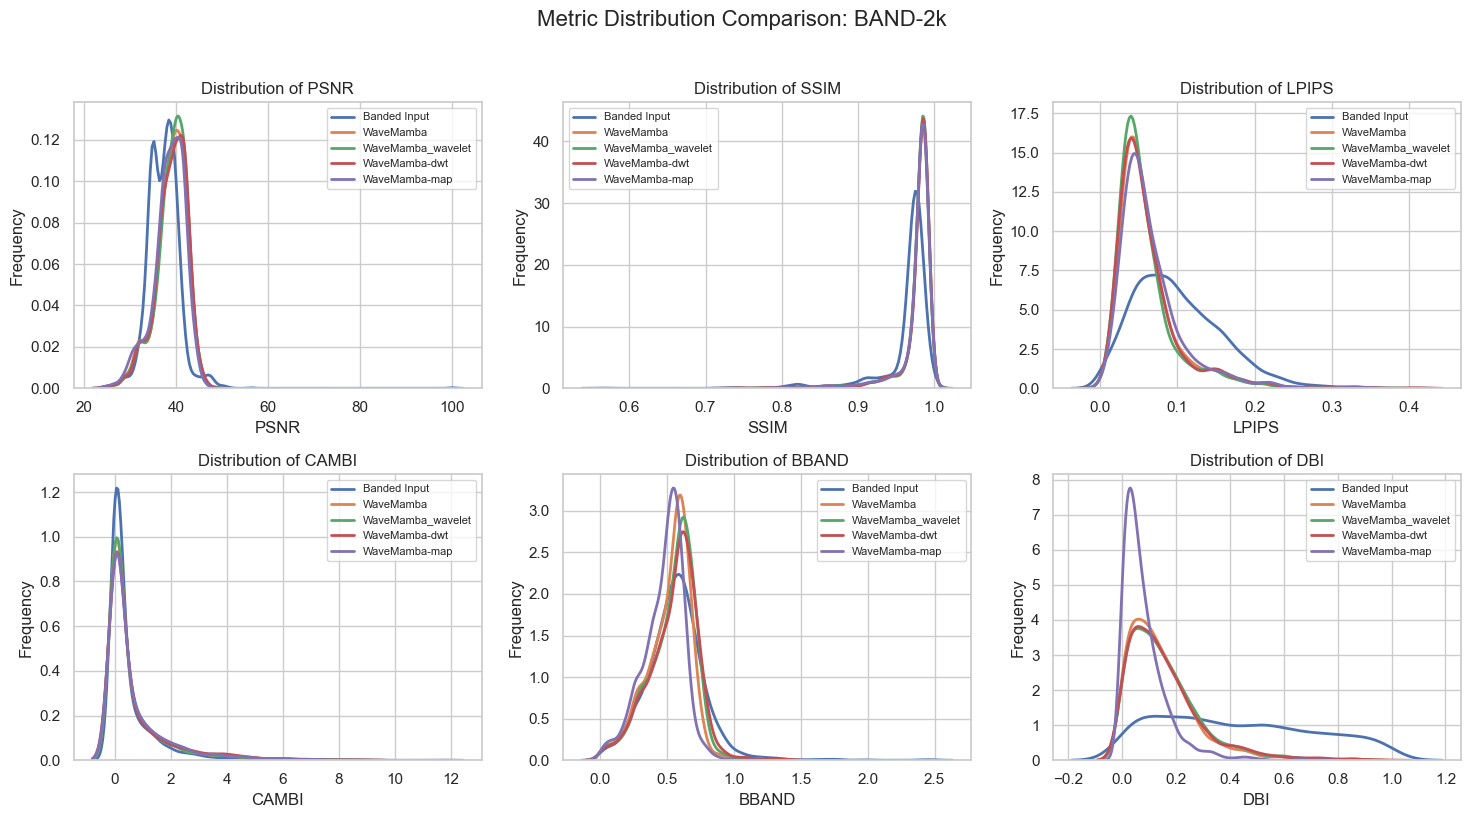

In [10]:
csv_paths = [
    "./combined_metrics/BAND-2k/combined_metrics_Banded_Input.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba_wavelet.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-dwt.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-map.csv",
]
labels = ["Banded Input", "WaveMamba", "WaveMamba_wavelet", "WaveMamba-dwt", "WaveMamba-map"]
dataset_name='BAND-2k'
compare_metric_distribution(csv_paths, dataset_name, labels)

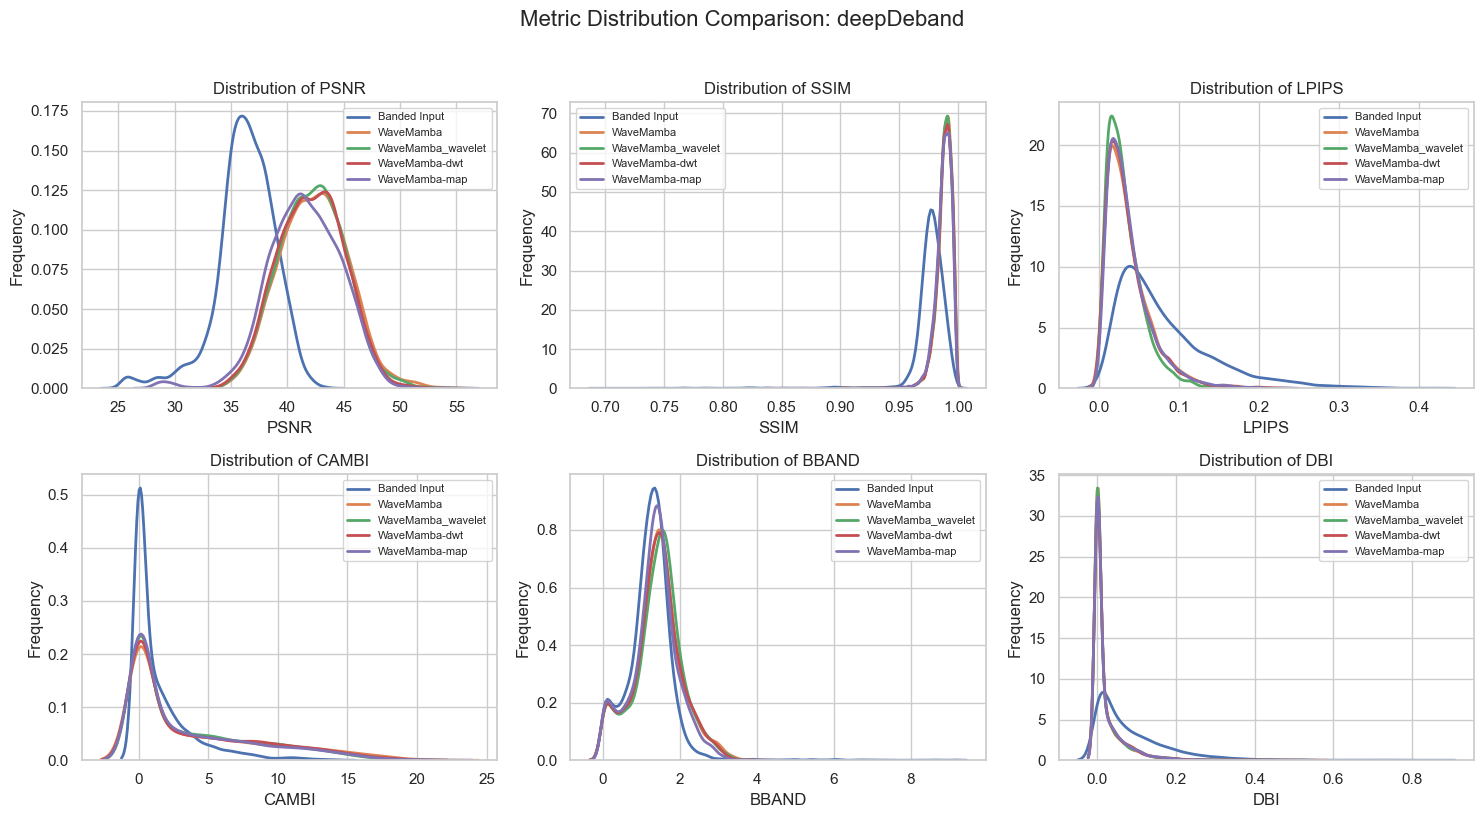

In [11]:
csv_paths = [
    "./combined_metrics/deepDeband/combined_metrics_Banded_Input.csv",
    "./combined_metrics/deepDeband/combined_metrics_WaveMamba.csv",
    "./combined_metrics/deepDeband/combined_metrics_WaveMamba_wavelet.csv",
    "./combined_metrics/deepDeband/combined_metrics_WaveMamba-dwt.csv",
    "./combined_metrics/deepDeband/combined_metrics_WaveMamba-map.csv",
]
labels = ["Banded Input", "WaveMamba", "WaveMamba_wavelet", "WaveMamba-dwt", "WaveMamba-map"]
dataset_name='deepDeband'
compare_metric_distribution(csv_paths, dataset_name, labels)

In [12]:
# plot_metrics_vs_mos("../test_img/BAND-2k.csv", "./combined_metrics/BAND-2k/combined_metrics_Banded_Input.csv", cols=3)
# plot_metrics_vs_mos("../test_img/BAND-2k.csv", "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-dwt.csv", cols=3)

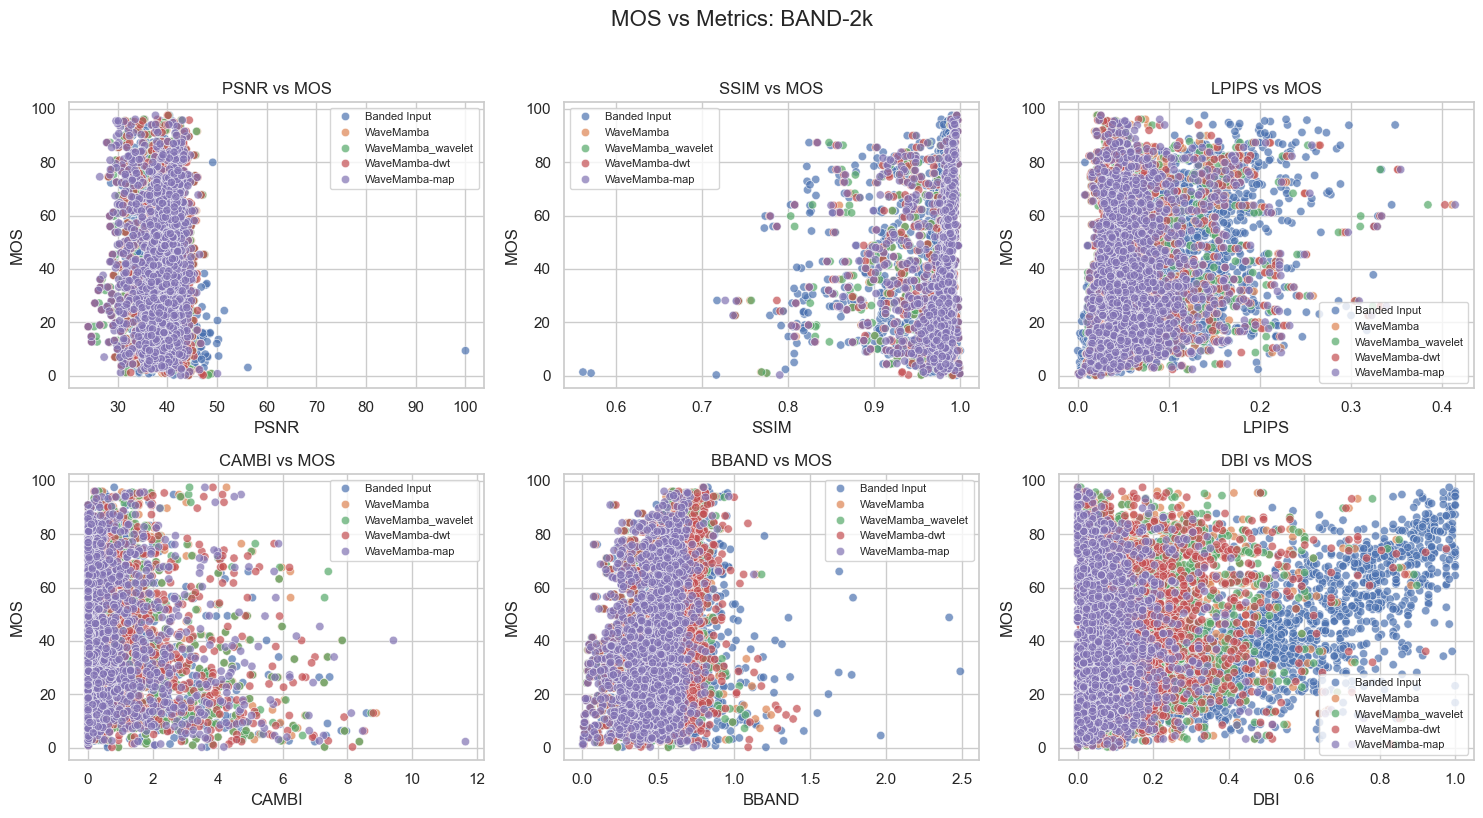

In [13]:
csv_paths = [
    "./combined_metrics/BAND-2k/combined_metrics_Banded_Input.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba_wavelet.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-dwt.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-map.csv",
]
labels = ["Banded Input", "WaveMamba", "WaveMamba_wavelet", "WaveMamba-dwt", "WaveMamba-map"]
mos_path = "./combined_metrics/BAND-2k/BAND-2k.csv"
plot_metrics_vs_mos_multi(mos_path, csv_paths, labels)

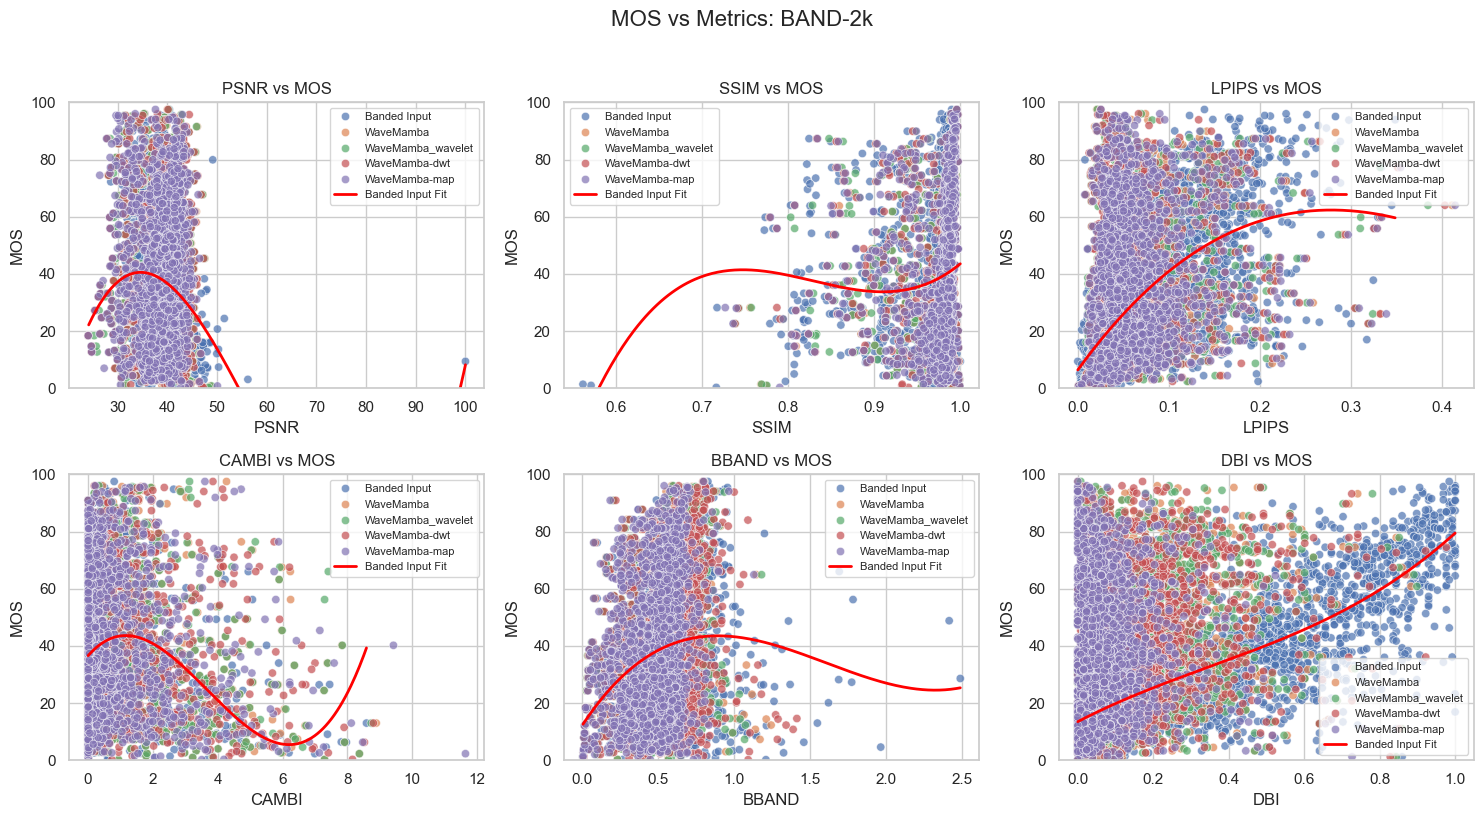

In [14]:
def plot_metrics_vs_mos_multi(mos_csv_path, metrics_csv_paths, labels, cols=3):
    mos_df = pd.read_csv(mos_csv_path)
    mos_df['filename'] = mos_df['filename'].str.strip().str.lower()

    all_data = []
    for path, label in zip(metrics_csv_paths, labels):
        metrics_df = pd.read_csv(path)
        metrics_df['filename'] = metrics_df['filename'].str.strip().str.lower()

        merged_df = pd.merge(metrics_df, mos_df[['filename', 'MOS']], on='filename')
        if merged_df.shape[0] == 0:
            print(f"Warning: No matched filenames for {label}")
            continue
        merged_df['method'] = label
        all_data.append(merged_df)
    df = pd.concat(all_data, ignore_index=True)

    desired_order = ['PSNR', 'SSIM', 'LPIPS', 'CAMBI', 'BBAND', 'DBI']
    metric_columns = [col for col in desired_order if col in df.columns]
    num_metrics = len(metric_columns)
    rows = math.ceil(num_metrics / cols)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, column in enumerate(metric_columns):
        ax = axes[i]
        sns.scatterplot(data=df, x=column, y='MOS', hue='method', ax=ax, alpha=0.7)

        # Banded Input 拟合线
        banded_df = df[df['method'] == 'Banded Input']
        if not banded_df.empty and column in banded_df.columns:
            x = banded_df[column]
            y = banded_df['MOS']
            valid = (~x.isna()) & (~y.isna()) & np.isfinite(x) & np.isfinite(y)
            x = x[valid]
            y = y[valid]
            if len(x) >= 5:
                try:
                    poly = np.polyfit(x, y, deg=3)
                    x_range = np.linspace(x.min(), x.max(), 200)
                    y_pred = np.polyval(poly, x_range)
                    ax.plot(x_range, y_pred, color='red', linewidth=2, label='Banded Input Fit')
                except np.linalg.LinAlgError:
                    print(f"Polynomial fitting failed for {column}. Skipped.")

        ax.set_ylim(0, 100)
        ax.set_title(f'{column} vs MOS')
        ax.set_xlabel(column)
        ax.set_ylabel('MOS')
        ax.legend(loc='best', fontsize=8)

    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"MOS vs Metrics: BAND-2k", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("../test_img/mos_vs_metrics_BAND-2k.png", dpi=300, bbox_inches='tight')
    plt.show()

csv_paths = [
    "./combined_metrics/BAND-2k/combined_metrics_Banded_Input.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba_wavelet.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-dwt.csv",
    "./combined_metrics/BAND-2k/combined_metrics_WaveMamba-map.csv",
]

labels = ["Banded Input", "WaveMamba", "WaveMamba_wavelet", "WaveMamba-dwt", "WaveMamba-map"]
mos_path = "./combined_metrics/BAND-2k/BAND-2k.csv"
plot_metrics_vs_mos_multi(mos_path, csv_paths, labels)